# Load Data

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# We import all the data for the training, evaluation and testing

data_training_validation = pd.read_csv("/Users/nicolabiagioli/Documents/Uni/Data Science Lab/Progetto/DSL_Winter_Project_2025/development.csv")
data_testing = pd.read_csv("/Users/nicolabiagioli/Documents/Uni/Data Science Lab/Progetto/DSL_Winter_Project_2025/evaluation.csv")

# Data Exploration

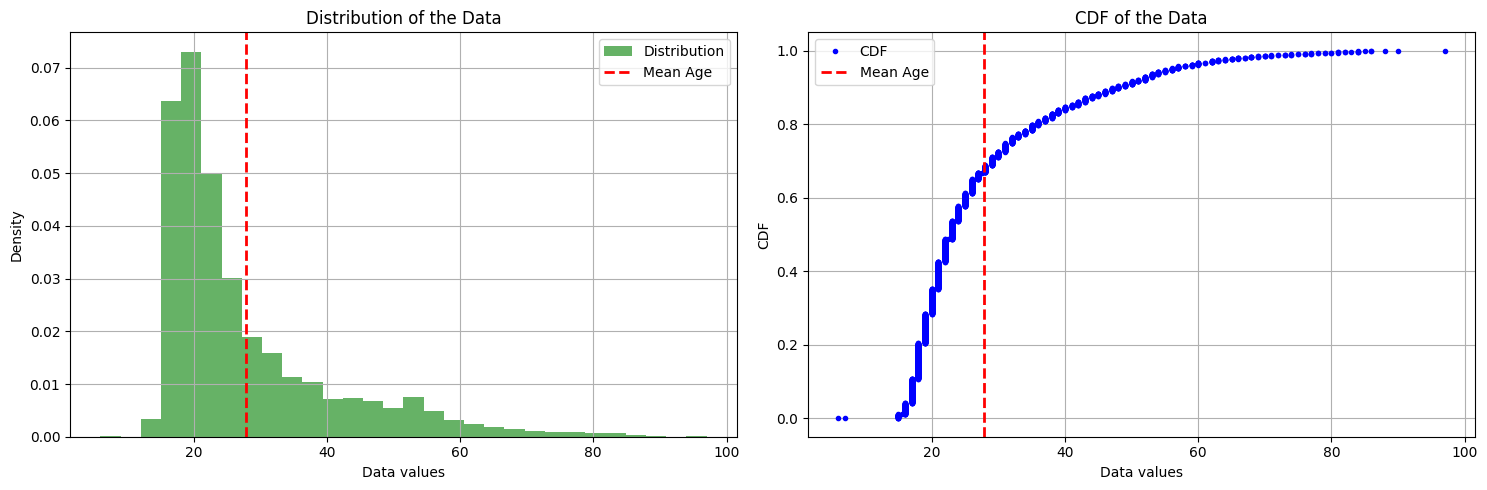

In [24]:
X = data_training_validation.drop(columns=['Id', 'age'])
y = data_training_validation['age']

datage = y
data_sorted = np.sort(datage)

cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

mean_age = np.mean(datage)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(datage, bins=30, density=True, alpha=0.6, color='g', label='Distribution')
ax1.axvline(mean_age, color='r', linestyle='dashed', linewidth=2, label='Mean Age')
ax1.set_xlabel('Data values')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of the Data')
ax1.grid(True)
ax1.legend()

ax2.plot(data_sorted, cdf, marker='.', linestyle='none', color='b', label='CDF')
ax2.axvline(mean_age, color='r', linestyle='dashed', linewidth=2, label='Mean Age')
ax2.set_xlabel('Data values')
ax2.set_ylabel('CDF')
ax2.set_title('CDF of the Data')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

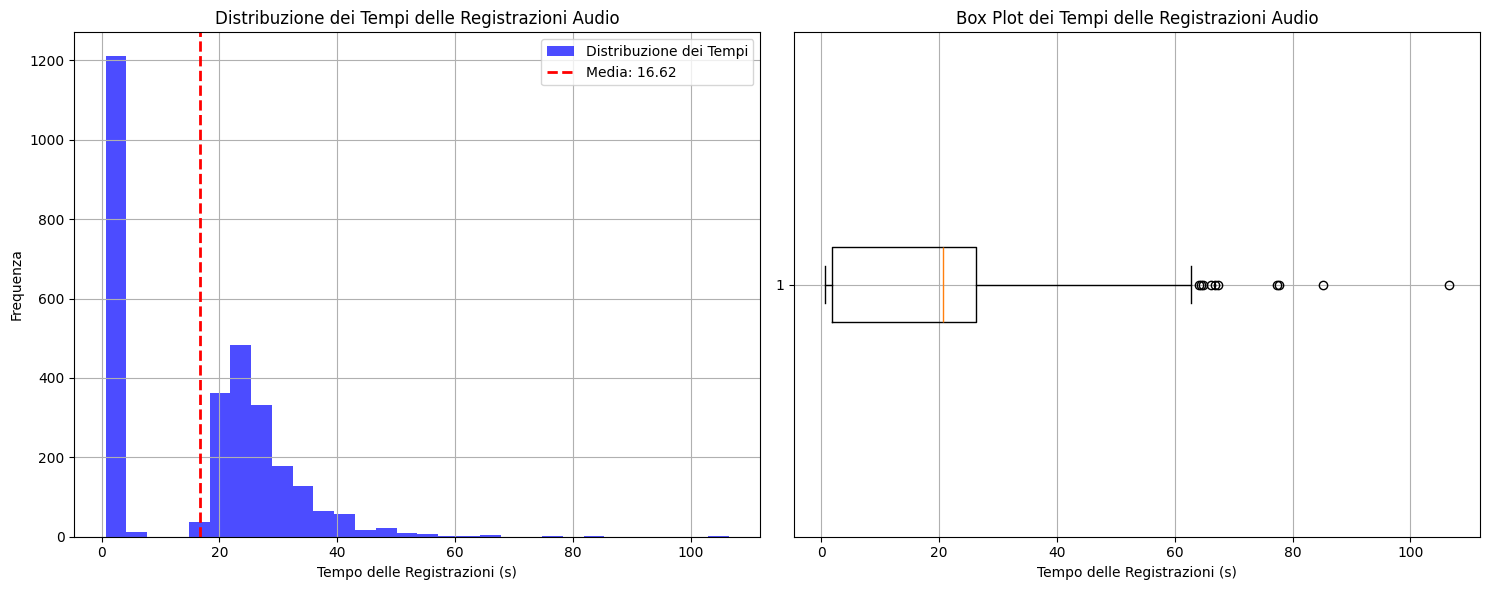

In [25]:
def get_audio_duration(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return librosa.get_duration(y=audio, sr=sr)

tempi_registrazioni = data_training_validation['path'].apply(lambda x: get_audio_duration(f"/Users/nicolabiagioli/Documents/Uni/Data Science Lab/Progetto/DSL_Winter_Project_2025/{x}"))

media_tempo = tempi_registrazioni.mean()

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(tempi_registrazioni, bins=30, color='blue', alpha=0.7, label='Distribuzione dei Tempi')
ax1.axvline(media_tempo, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media_tempo:.2f}')
ax1.set_xlabel('Tempo delle Registrazioni (s)')
ax1.set_ylabel('Frequenza')
ax1.set_title('Distribuzione dei Tempi delle Registrazioni Audio')
ax1.legend()
ax1.grid(True)

ax3.boxplot(tempi_registrazioni, vert=False)
ax3.set_xlabel('Tempo delle Registrazioni (s)')
ax3.set_title('Box Plot dei Tempi delle Registrazioni Audio')
ax3.grid(True)

plt.tight_layout()
plt.show()


Età: 28.0
Sesso: male


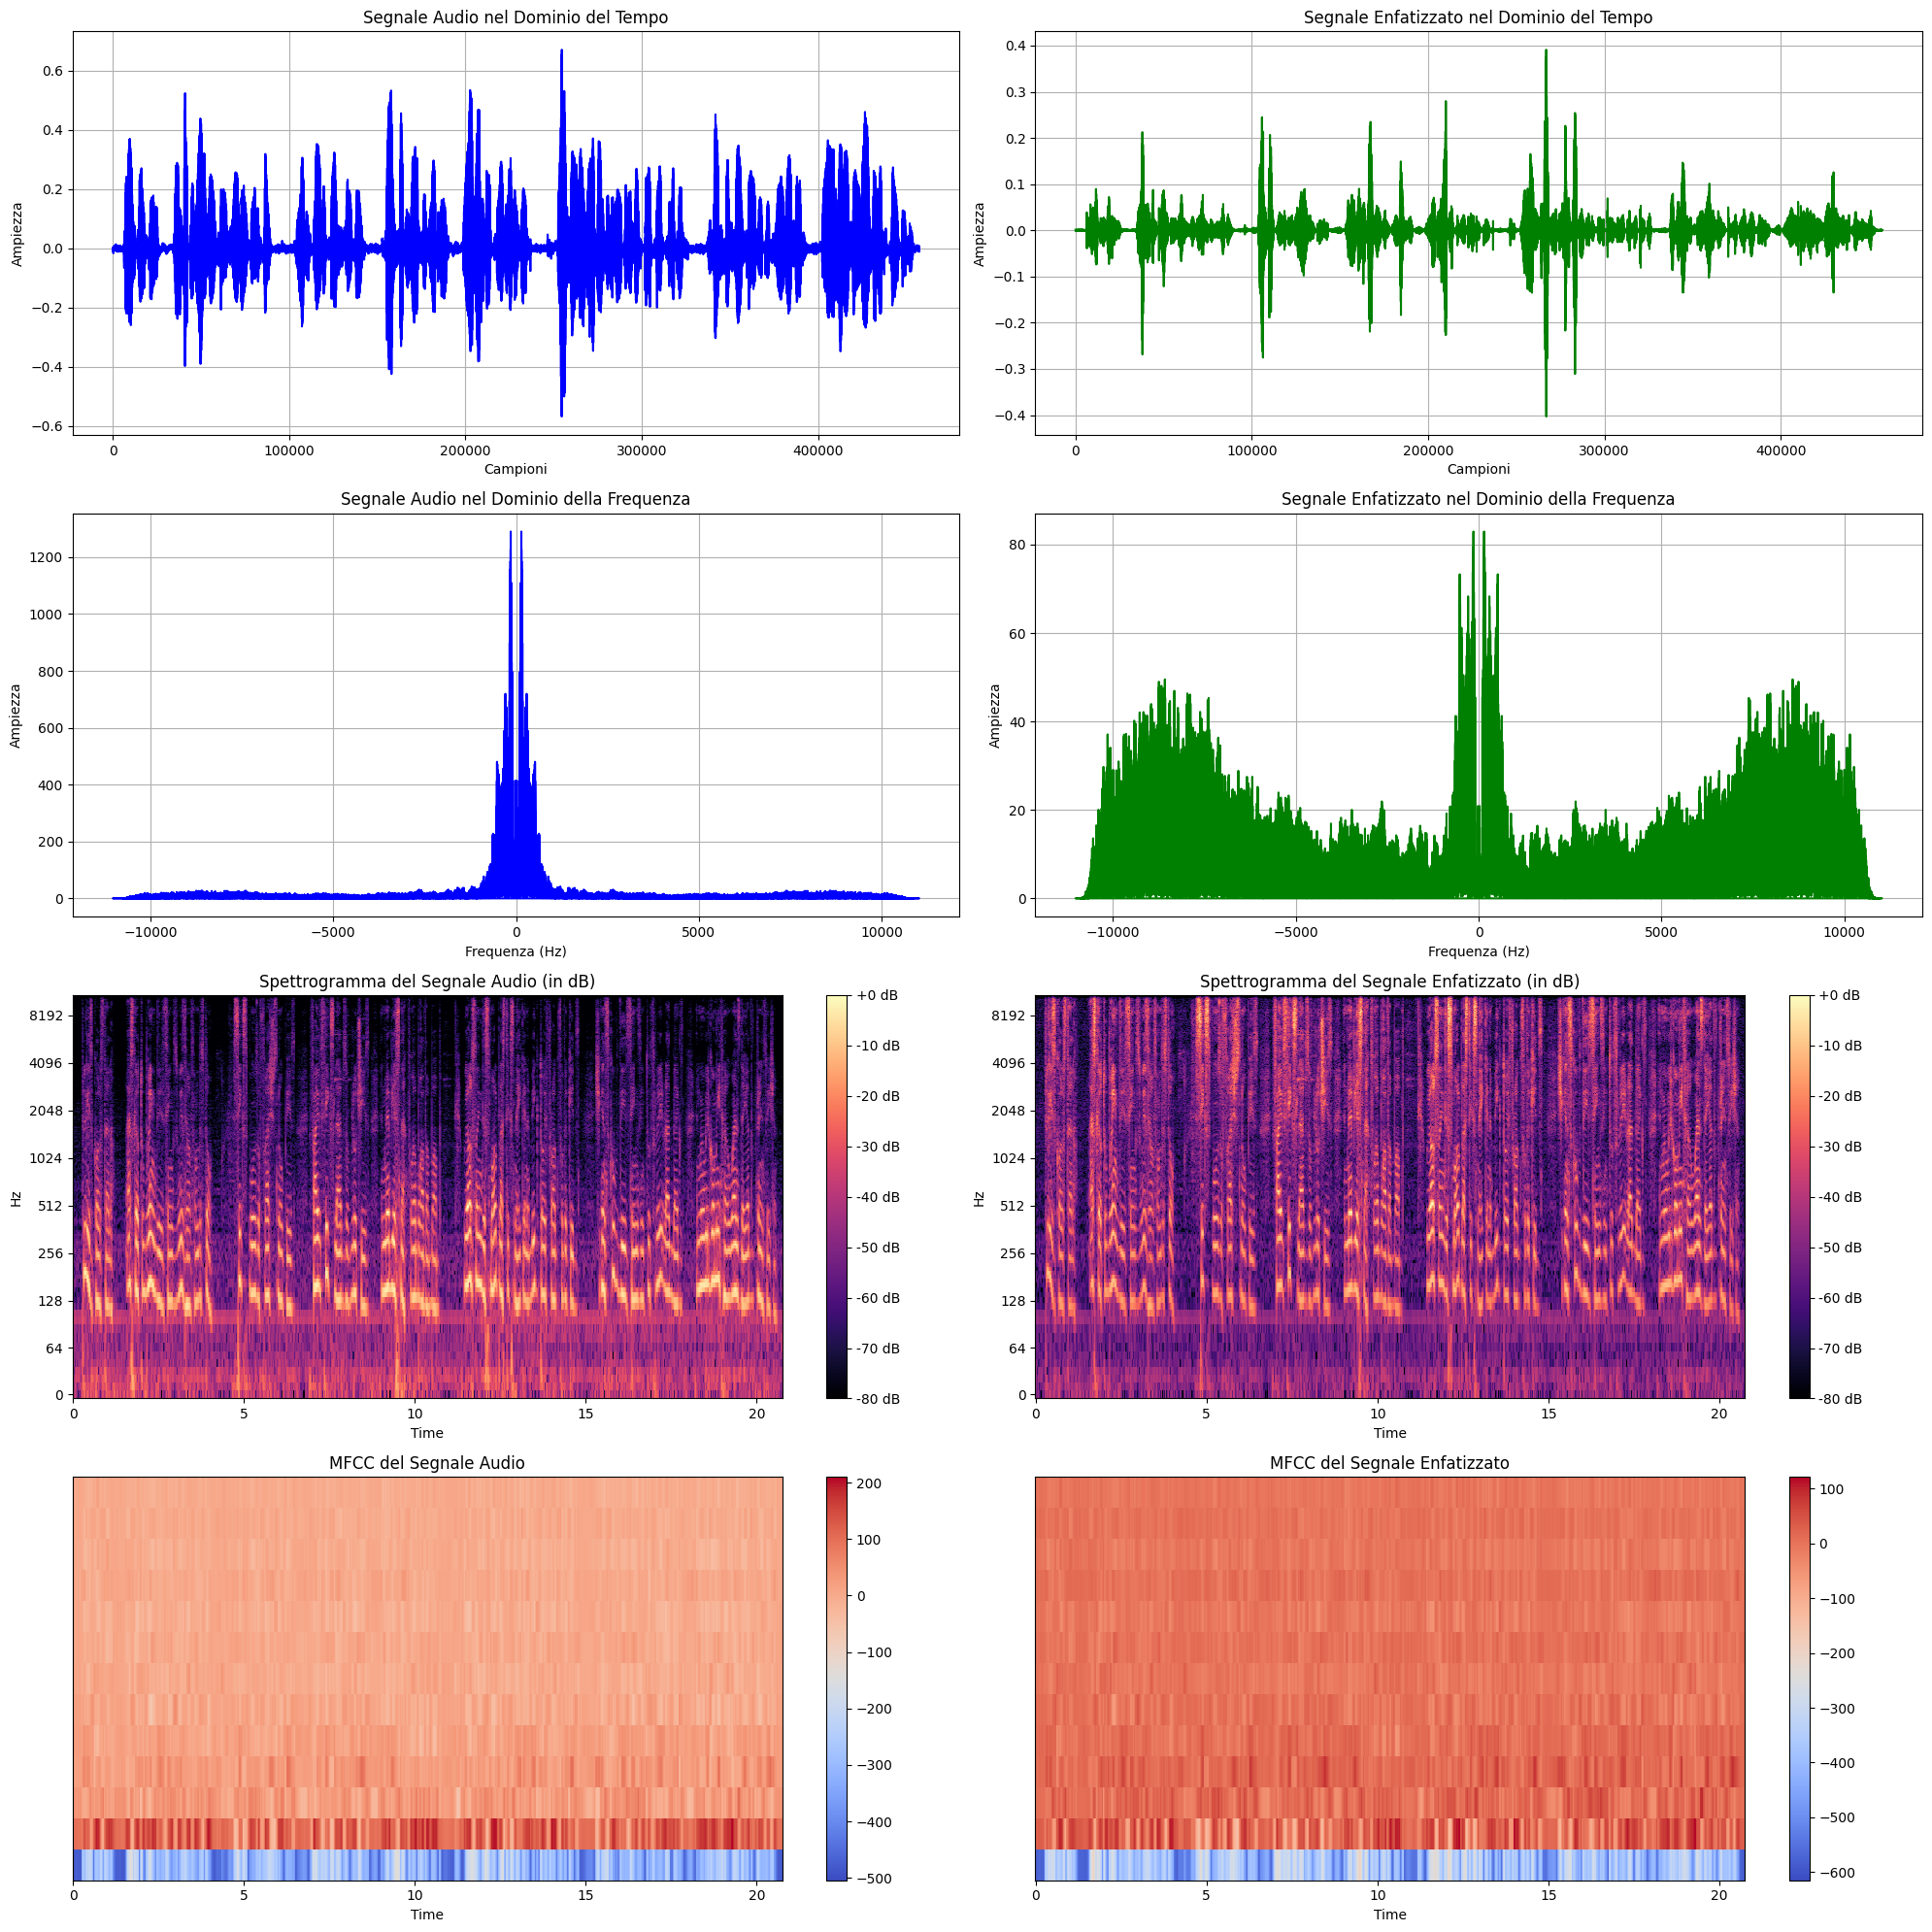

In [26]:
audios = data_training_validation["path"]

audio_id = 10

print(f"Età: {data_training_validation['age'][audio_id]}")
print(f"Sesso: {data_training_validation['gender'][audio_id]}")

audio_path = f"/Users/nicolabiagioli/Documents/Uni/Data Science Lab/Progetto/DSL_Winter_Project_2025/{audios[audio_id]}"
audio, sr = librosa.load(audio_path, sr=data_training_validation['sampling_rate'][audio_id])

audio_fft = np.fft.fft(audio)
frequencies = np.fft.fftfreq(len(audio), 1/sr)

S = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

# Compute the pre-emphasis of the audio signal
alpha = 0.95  
pre_emphasized_signal = np.append(audio[0], audio[1:] - alpha * audio[:-1])

# Compute the spectrogram of the pre-emphasized signal
S_pre_emphasized = librosa.stft(pre_emphasized_signal)
S_db_pre_emphasized = librosa.amplitude_to_db(np.abs(S_pre_emphasized), ref=np.max)

# Compute the MFCC of the pre-emphasized signal
mfccs_pre_emphasized = librosa.feature.mfcc(y=pre_emphasized_signal, sr=sr, n_mfcc=13)

fig, axes = plt.subplots(4, 2, figsize=(20, 20))

axes[0, 0].plot(audio, color='blue')
axes[0, 0].set_title('Segnale Audio nel Dominio del Tempo')
axes[0, 0].set_xlabel('Campioni')
axes[0, 0].set_ylabel('Ampiezza')
axes[0, 0].grid(True)

axes[0, 1].plot(pre_emphasized_signal, color='g')
axes[0, 1].set_title('Segnale Enfatizzato nel Dominio del Tempo')
axes[0, 1].set_xlabel('Campioni')
axes[0, 1].set_ylabel('Ampiezza')
axes[0, 1].grid(True)

axes[1, 0].plot(frequencies, np.abs(audio_fft), color='blue')
axes[1, 0].set_title('Segnale Audio nel Dominio della Frequenza')
axes[1, 0].set_xlabel('Frequenza (Hz)')
axes[1, 0].set_ylabel('Ampiezza')
axes[1, 0].grid(True)

axes[1, 1].plot(frequencies, np.abs(np.fft.fft(pre_emphasized_signal)), color='g')
axes[1, 1].set_title('Segnale Enfatizzato nel Dominio della Frequenza')
axes[1, 1].set_xlabel('Frequenza (Hz)')
axes[1, 1].set_ylabel('Ampiezza')
axes[1, 1].grid(True)

img1 = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[2, 0])
axes[2, 0].set_title('Spettrogramma del Segnale Audio (in dB)')
fig.colorbar(img1, ax=axes[2, 0], format='%+2.0f dB')

img3 = librosa.display.specshow(S_db_pre_emphasized, sr=sr, x_axis='time', y_axis='log', ax=axes[2, 1])
axes[2, 1].set_title('Spettrogramma del Segnale Enfatizzato (in dB)')
fig.colorbar(img3, ax=axes[2, 1], format='%+2.0f dB')

img2 = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[3, 0])
axes[3, 0].set_title('MFCC del Segnale Audio')
fig.colorbar(img2, ax=axes[3, 0])

img4 = librosa.display.specshow(mfccs_pre_emphasized, sr=sr, x_axis='time', ax=axes[3, 1])
axes[3, 1].set_title('MFCC del Segnale Enfatizzato')
fig.colorbar(img4, ax=axes[3, 1])

plt.tight_layout()
plt.show()

In [27]:
# Search for null or zero values in the dataset
null_counts = X.isnull().sum()

zero_counts = (X == 0).sum()

null_counts_table = pd.DataFrame({
    'Column': null_counts.index,
    'Null Count': null_counts.values,
    'Zero Count': zero_counts.values
})

print(null_counts_table)


                    Column  Null Count  Zero Count
0            sampling_rate           0           0
1                   gender           0           0
2                ethnicity           0           0
3               mean_pitch           0           0
4                max_pitch           0           0
5                min_pitch           0           0
6                   jitter           0           0
7                  shimmer           0           0
8                   energy           0           0
9                 zcr_mean           0           0
10  spectral_centroid_mean           0           0
11                   tempo           0           0
12                     hnr           0           0
13               num_words           0         409
14          num_characters           0         409
15              num_pauses           0           0
16        silence_duration           0           0
17                    path           0           0


# Data Pre-Processing

In [7]:
# Define the function to extract the additional features from the audio files
def extract_additional_features(row):
    file_path = f"/Users/nicolabiagioli/Documents/Uni/Data Science Lab/Progetto/DSL_Winter_Project_2025/{row[0]}"
    audio, sr = librosa.load(file_path, sr=None)
    features = []

    # Compute the pre-emphasis of the audio signal
    alpha = 0.95
    pre_emphasized_signal = np.append(audio[0], audio[1:] - alpha * audio[:-1])

    # Compute the standard deviation of the fundamental frequency(F0)
    pitches, magnitudes = librosa.piptrack(y=pre_emphasized_signal, sr=sr)
    f0_values = pitches[pitches > 0]

    features.append(np.std(f0_values) if len(f0_values) > 0 else 0)
    
    # Compute the mean of the fundamental frequency(F0)
    features.append(np.mean(f0_values) if len(f0_values) > 0 else 0)
    
    # Compute the stregth of the pitch
    features.append(np.mean(magnitudes) if len(magnitudes) > 0 else 0)

    # Compute the standard deviation of the root mean square energy
    rms = librosa.feature.rms(y=pre_emphasized_signal)[0]
    features.append(np.std(rms))

    # Compute the alpha ratio
    stft = np.abs(librosa.stft(pre_emphasized_signal))
    frequencies = librosa.fft_frequencies(sr=sr)

    low_freq_mask = (frequencies < 1000)
    high_freq_mask = (frequencies >= 1000) & (frequencies < 5000)

    low_freq_energy = np.sum(stft[low_freq_mask], axis=0)
    high_freq_energy = np.sum(stft[high_freq_mask], axis=0)

    features.append(np.mean(low_freq_energy) / (np.mean(high_freq_energy) if np.mean(high_freq_energy) > 0 else 1))

    # Compute the spectral tilt
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=pre_emphasized_signal, sr=sr)
    features.append(np.mean(spectral_bandwidth))

    # Compute the spectral slope
    spectral_centroid = librosa.feature.spectral_centroid(y=pre_emphasized_signal, sr=sr)
    x = np.arange(len(spectral_centroid.flatten()))
    y = spectral_centroid.flatten()
    reg = np.polyfit(x, y, 1)
    
    features.append(reg[0]) 

    # Compute the human factor cepstral coefficients (HFCC) and delta HFCC
    mfccs = librosa.feature.mfcc(y=pre_emphasized_signal, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs))
    features.append(np.mean(librosa.feature.delta(mfccs)))

    # Compute the mel-frequency cepstral coefficients (MFCC)
    for mfcc in mfccs:
        features.append(np.mean(mfcc))
        features.append(np.std(mfcc))

    return np.array(features)

In [10]:
# Define the method to remove the brackets from the tempo column
def remove_brackets(X):
    return X['tempo'].apply(lambda x: x.strip('[]')).astype(float).values.reshape(-1, 1)

# Define the method to remove a column from the dataset
def remove_column(X, column_index):
    return np.delete(X, column_index, axis=1)

# Randmom Forest

In [ ]:
X_train = data_training_validation.drop(columns=['Id', 'age'])
y_train = data_training_validation['age']


print(X_train.loc[0])
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Random Forest Pipeline

In [12]:
# Define the preprocessor to extract discretize categorical features and adapt tempo feature from string to float
preprocessor = ColumnTransformer(
    transformers=[
        ('path', 'passthrough', ['path']),
        ("sample_rate", 'passthrough', ['sampling_rate']),
        ('ethnicity', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['ethnicity']),
        ('gender', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['gender']),
        ('tempo', FunctionTransformer(remove_brackets), ['tempo']),
    ],
    remainder='passthrough'
)


In [ ]:
# Define the pipeline to extract additional features from the audio files
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('extract_additional_features', FunctionTransformer(lambda X: np.hstack([X, np.apply_along_axis(extract_additional_features, 1, X)]), validate=False)),
    ('remove_path', FunctionTransformer(remove_column, kw_args={'column_index': 0}, validate=False)),
    ('remove_sampling_rate', FunctionTransformer(remove_column, kw_args={'column_index': 0}, validate=False))
])

# Fit and transform the training and validation data
X_train_transformed_rf = pipeline.fit_transform(X_train_split)
X_val_transformed_rf = pipeline.transform(X_val_split)

print(f"Dimensioni dei dati di addestramento trasformati: {X_train_transformed_rf.shape}")
print(f"Dimensioni dei dati di test trasformati: {X_val_transformed_rf.shape}")

### Model training and evaluation

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4, 6, 8],    
}

#Best parameters found for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
#Random Forest - Root Mean Squared Error (RMSE): 9.448413000199658

rf = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train_transformed_rf, y_train_split)

print(f"Best parameters found for Random Forest: {grid_search_rf.best_params_}")

# Predict the target values using the best model
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_val_transformed_rf)

mse_rf = mean_squared_error(y_val_split, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest - Root Mean Squared Error (RMSE): {rmse_rf}")

### Generate submission file for the Random Forest model

In [ ]:
# transform the test data to the same format expected by the model
X_test_transformed_rf = pipeline.transform(data_testing.drop(columns=['Id']))

y_test_pred = best_model_rf.predict(X_test_transformed_rf)

submission = pd.DataFrame({
    'Id': data_testing['Id'],
    'Predicted': y_test_pred
})

print(submission.head())

submission.to_csv('submission_rf.csv', index=False)

# Lasso

In [ ]:
X_train = data_training_validation.drop(columns=['Id', 'age'])
y_train = data_training_validation['age']


print(X_train.loc[0])
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Lasso pipeline

In [18]:
# Define a preprocessor for the categorical features 
preprocessor_cat = ColumnTransformer(
    transformers=[
        ('path', 'passthrough', ['path']),
        ("sample_rate", 'passthrough', ['sampling_rate']),
        ('gender', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['gender']),
        ('ethnicity', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['ethnicity']),
    ],
    remainder='drop'
)

# Define a preprocessor for the numerical features 
preprocessor_num = ColumnTransformer(
    transformers=[
        ('path', 'passthrough', ['path']),
        ("sample_rate", 'passthrough', ['sampling_rate']),
        ('gender', 'drop', ['gender']),
        ('ethnicity', 'drop', ['ethnicity']),
        ('tempo', FunctionTransformer(remove_brackets), ['tempo']),
    ],
    remainder='passthrough'
)

In [ ]:
# Define the pipeline for the categorical features
pipeline_cat = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('remove_path', FunctionTransformer(remove_column, kw_args={'column_index': 0}, validate=False)),
    ('remove_sampling_rate', FunctionTransformer(remove_column, kw_args={'column_index': 0}, validate=False))
])

# Define the pipeline for the numerical features
pipeline_num = Pipeline(steps=[
    ('preprocessor', preprocessor_num),
    ('extract_additional_features', FunctionTransformer(lambda X: np.hstack([X, np.apply_along_axis(extract_additional_features, 1, X)]), validate=False)),
    ('remove_path', FunctionTransformer(remove_column, kw_args={'column_index': 0}, validate=False)),
    ('remove_sampling_rate', FunctionTransformer(remove_column, kw_args={'column_index': 0}, validate=False)),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler())
])


# Fit the pipeline on the training data, and concatenate the transformed data to abtain the transformed training data
X_train_transformed_lasso_cat = pipeline_cat.fit_transform(X_train_split)
X_train_transformed_lasso_num = pipeline_num.fit_transform(X_train_split)
X_train_transformed_lasso = np.hstack([X_train_transformed_lasso_cat, X_train_transformed_lasso_num])

# Transform the validation data, and concatenate the transformed data to abtain the transformed validation data
X_val_transformed_lasso_cat = pipeline_cat.transform(X_val_split)
X_val_transformed_lasso_num = pipeline_num.transform(X_val_split)
X_val_transformed_lasso = np.hstack([X_val_transformed_lasso_cat, X_val_transformed_lasso_num])  

print(f"Dimensioni dei dati di addestramento trasformati: {X_train_transformed_lasso.shape}")
print(X_train_transformed_lasso)
print(f"Dimensioni dei dati di test trasformati: {X_val_transformed_lasso.shape}")


### Model training and evaluation

In [ ]:
param_grid_lasso = {
    'alpha': np.logspace(-4, 1, 40),
}

lasso = Lasso()

# Initialize the grid search with the Lasso model
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=8, n_jobs=-1, verbose=2)

grid_search_lasso.fit(X_train_transformed_lasso, y_train_split)

print(f"Best parameters found for Lasso: {grid_search_lasso.best_params_}")

# Evaluate the best model found on the validation data
best_model_lasso = grid_search_lasso.best_estimator_
y_pred_lasso = best_model_lasso.predict(X_val_transformed_lasso)

mse_lasso = mean_squared_error(y_val_split, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)

print(f"Lasso Regression - Root Mean Squared Error (RMSE): {rmse_lasso}")

### Generate submission file for the Lasso model

In [ ]:
# Transform the test data, and concatenate the transformed data to abtain the transformed test data
X_test_transformed_lasso_cat = pipeline_cat.transform(data_testing.drop(columns=['Id']))
X_test_transformed_lasso_num = pipeline_num.transform(data_testing.drop(columns=['Id']))
X_test_transformed_lasso = np.hstack([X_test_transformed_lasso_cat, X_test_transformed_lasso_num])

y_test_pred = best_model_lasso.predict(X_test_transformed_lasso)

submission = pd.DataFrame({
    'Id': data_testing['Id'],
    'Predicted': y_test_pred
})

print(submission.head())

submission.to_csv('submission_lasso.csv', index=False)

# Model comparison

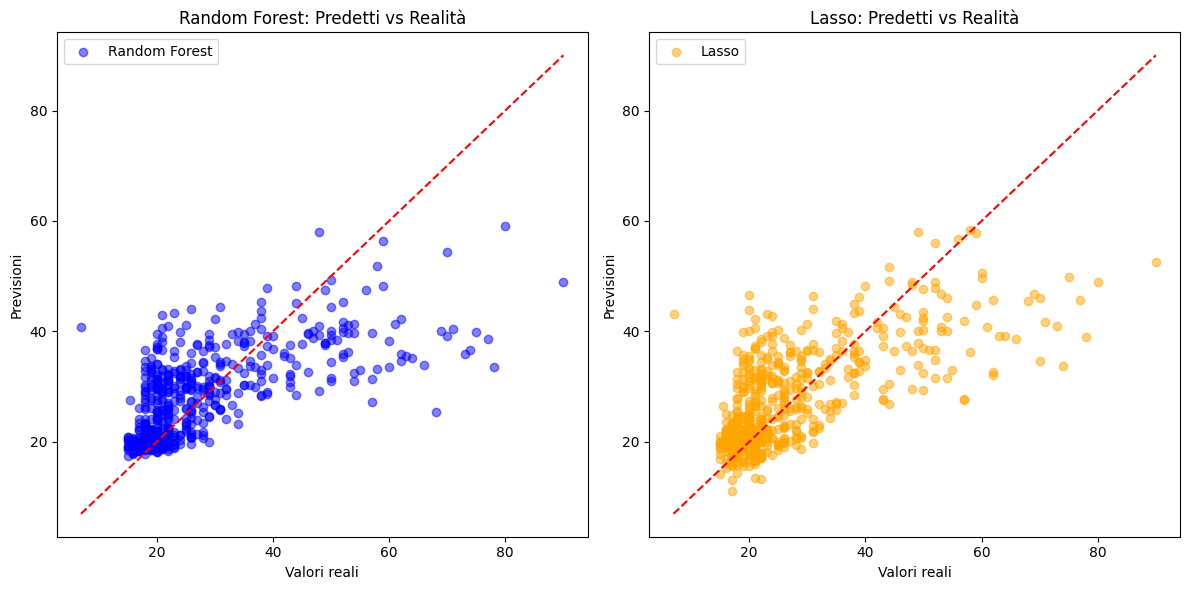

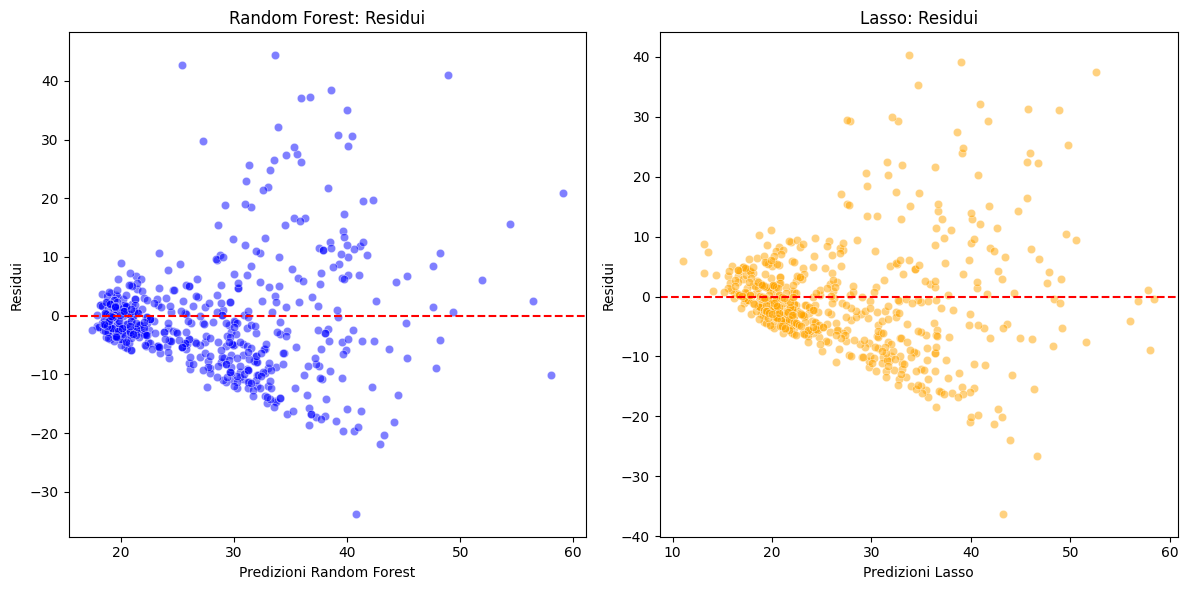

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_pred_lasso
y_pred_rf
y_val_split


# Calcolare i residui (errore) per entrambi i modelli
rf_residuals = y_val_split - y_pred_rf
lasso_residuals = y_val_split - y_pred_lasso

# 1. Grafico a dispersione (Predetti vs Realità)
plt.figure(figsize=(12, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_val_split, y_pred_rf, color='blue', alpha=0.5, label='Random Forest')
plt.plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], color='red', linestyle='--')  # Linea di riferimento
plt.xlabel('Valori reali')
plt.ylabel('Previsioni')
plt.title('Random Forest: Predetti vs Realità')
plt.legend()

# Lasso
plt.subplot(1, 2, 2)
plt.scatter(y_val_split, y_pred_lasso, color='orange', alpha=0.5, label='Lasso')
plt.plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], color='red', linestyle='--')  # Linea di riferimento
plt.xlabel('Valori reali')
plt.ylabel('Previsioni')
plt.title('Lasso: Predetti vs Realità')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Grafico dei residui
plt.figure(figsize=(12, 6))

# Random Forest Residui
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_rf, y=rf_residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Linea orizzontale per zero
plt.xlabel('Predizioni Random Forest')
plt.ylabel('Residui')
plt.title('Random Forest: Residui')

# Lasso Residui
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_lasso, y=lasso_residuals, color='orange', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Linea orizzontale per zero
plt.xlabel('Predizioni Lasso')
plt.ylabel('Residui')
plt.title('Lasso: Residui')

plt.tight_layout()
plt.show()
